<a href="https://colab.research.google.com/github/Maxsiglo21/Robot_Trading/blob/main/Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robot Trading en Python

## 1 - Configurando el ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
# Versiones de las bibliotecas a utilzar
!python -V
print(' ')
!pip show pandas | grep 'Name\|Version'
print(' ')
!pip show Numpy | grep 'Name\|Version'
print(' ')
!pip show matplotlib | grep 'Name\|Version'

Python 3.10.12
 
Name: pandas
Version: 1.5.3
 
Name: numpy
Version: 1.23.5
 
Name: matplotlib
Version: 3.7.1


In [3]:
# otras bibliotecas necesarias

import seaborn as sns
# biblioteca para manipular fechas y horas
import time
# biblioteca para acceder a datos financieros de Yahoo Finance
import yfinance as yf
from bs4 import BeautifulSoup
import requests
# biblioteca para manipular fechas y hora
import datetime
# biblioteca para resolucion de problemas horarios ambiguos y multiplataforma
import pytz
# biblioteca de visualización y limpieza de pantalla
from IPython.display import clear_output



## 2 - Obtención de datos

In [4]:
# Extraer datos hitóricos financieros utilizando la biblioteca yfinance de Python, para extraer el histórico
# de precios del Bitcoin en dólares BTC-USD, de los últimos 7 días.

def importar_base_bitcoin():
  global df_bitcoin
  data = yf.Ticker("BTC-USD").history(period='7d', interval='5m')
  df_bitcoin = pd.DataFrame(data)
  return df_bitcoin

importar_base_bitcoin()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-23 00:00:00+00:00,30002.443359,30002.443359,29939.513672,29950.691406,0,0.0,0.0
2023-10-23 00:05:00+00:00,29968.242188,29976.166016,29949.933594,29949.933594,19917824,0.0,0.0
2023-10-23 00:10:00+00:00,29957.041016,29987.125000,29957.041016,29965.908203,19190784,0.0,0.0
2023-10-23 00:15:00+00:00,29979.537109,29979.537109,29965.908203,29965.908203,0,0.0,0.0
2023-10-23 00:20:00+00:00,29975.019531,29975.019531,29928.232422,29928.232422,5450752,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-29 12:45:00+00:00,34352.156250,34400.664062,34350.429688,34385.808594,2671616,0.0,0.0
2023-10-29 12:50:00+00:00,34392.445312,34405.261719,34383.984375,34383.984375,14336,0.0,0.0
2023-10-29 12:55:00+00:00,34397.535156,34418.199219,34397.535156,34417.011719,0,0.0,0.0


## ° Indicadores de tendencias

In [5]:
# Función de tendencia utilizando la biblioteca BeautifulSoup, con Web Scraping

def extraer_tendencias():
    global precio_actual,tendencia
    url = 'https://coinmarketcap.com/'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    precio_btc = soup.find('div', class_='sc-a0353bbc-0 gDrtaY').get_text()
    precio_btc = precio_btc.replace(',', '')
    precio_btc = precio_btc.replace('$', '')
    precio_actual = float(precio_btc)
    icon = soup.findAll('span', {'class':['sc-d55c02b-0 iwhBxy','sc-97d6d2ca-0 bQjSqS']})[0]
    if 'sc-d55c02b-0 iwhBxy' in ' '.join(icon['class']):
        tendencia = 'alta'
    else:
        tendencia = 'baja'
    variacion = soup.find('span', class_='sc-d55c02b-0 iwhBxy').get_text()
    return [precio_actual, tendencia, variacion]

extraer_tendencias()

[34454.23, 'alta', '0.30%']

# 3 - Limpieza de Datos

In [6]:
# Para la limpieza de datos utilizamos los atributos Datetime, Close y Volume. Se trabajó con
# los valores en 'Volume' con valores superiores a cero, eliminando el resto.
# Se identifican y eliminan los outliers en el precio del Bitcoin de la columna 'Close'
# Se seleccionan los registros cuyo precio (close) se encuentran entre el 1° y 3° cuartil
# Se calcula el precio promedio.
# Antes de limpiar la base, se crea una copia de la  basse bf_bitcoin, sin modificar la base original


def limpieza_datos():
  global media_bitcoin,df_bitcoin_limpio
  df = importar_base_bitcoin()
  df_bitcoin_limpio = df.copy()
  indices_unicos = df_bitcoin_limpio.index.drop_duplicates()
  df_bitcoin_limpio = df_bitcoin_limpio.reindex(indices_unicos)
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
  close = df_bitcoin_limpio['Close']
  Q1 = close.quantile(.25)
  Q3 = close.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  seleccion = ((close >= Q1) & (close < Q3))
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  return [df_bitcoin_limpio, Q1, Q3]

limpieza_datos()

[                                   Open          High           Low  \
 Datetime                                                              
 2023-10-23 16:50:00+00:00  31135.460938  31197.968750  31130.431641   
 2023-10-23 16:55:00+00:00  31204.603516  31287.503906  31204.603516   
 2023-10-23 17:00:00+00:00  31232.820312  31232.820312  31135.216797   
 2023-10-23 17:05:00+00:00  31172.080078  31314.574219  31172.080078   
 2023-10-23 17:10:00+00:00  31280.162109  31280.162109  31212.583984   
 ...                                 ...           ...           ...   
 2023-10-29 09:30:00+00:00  34245.093750  34265.476562  34241.316406   
 2023-10-29 09:35:00+00:00  34252.703125  34252.703125  34248.363281   
 2023-10-29 09:45:00+00:00  34240.835938  34250.007812  34236.050781   
 2023-10-29 10:10:00+00:00  34193.148438  34199.617188  34190.062500   
 2023-10-29 10:45:00+00:00  34188.214844  34188.214844  34180.589844   
 
                                   Close     Volume  Dividends

In [7]:
df_new = pd.DataFrame(df_bitcoin_limpio)

In [8]:
df_new

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-23 16:50:00+00:00,31135.460938,31197.968750,31130.431641,31197.968750,147929088,0.0,0.0
2023-10-23 16:55:00+00:00,31204.603516,31287.503906,31204.603516,31270.189453,272463872,0.0,0.0
2023-10-23 17:00:00+00:00,31232.820312,31232.820312,31135.216797,31135.216797,207448064,0.0,0.0
2023-10-23 17:05:00+00:00,31172.080078,31314.574219,31172.080078,31279.712891,114763776,0.0,0.0
2023-10-23 17:10:00+00:00,31280.162109,31280.162109,31212.583984,31220.367188,132339712,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-29 09:30:00+00:00,34245.093750,34265.476562,34241.316406,34257.300781,13413376,0.0,0.0
2023-10-29 09:35:00+00:00,34252.703125,34252.703125,34248.363281,34248.445312,10973184,0.0,0.0
2023-10-29 09:45:00+00:00,34240.835938,34250.007812,34236.050781,34249.148438,7535616,0.0,0.0


# Gráfico de precios de Bitcoin

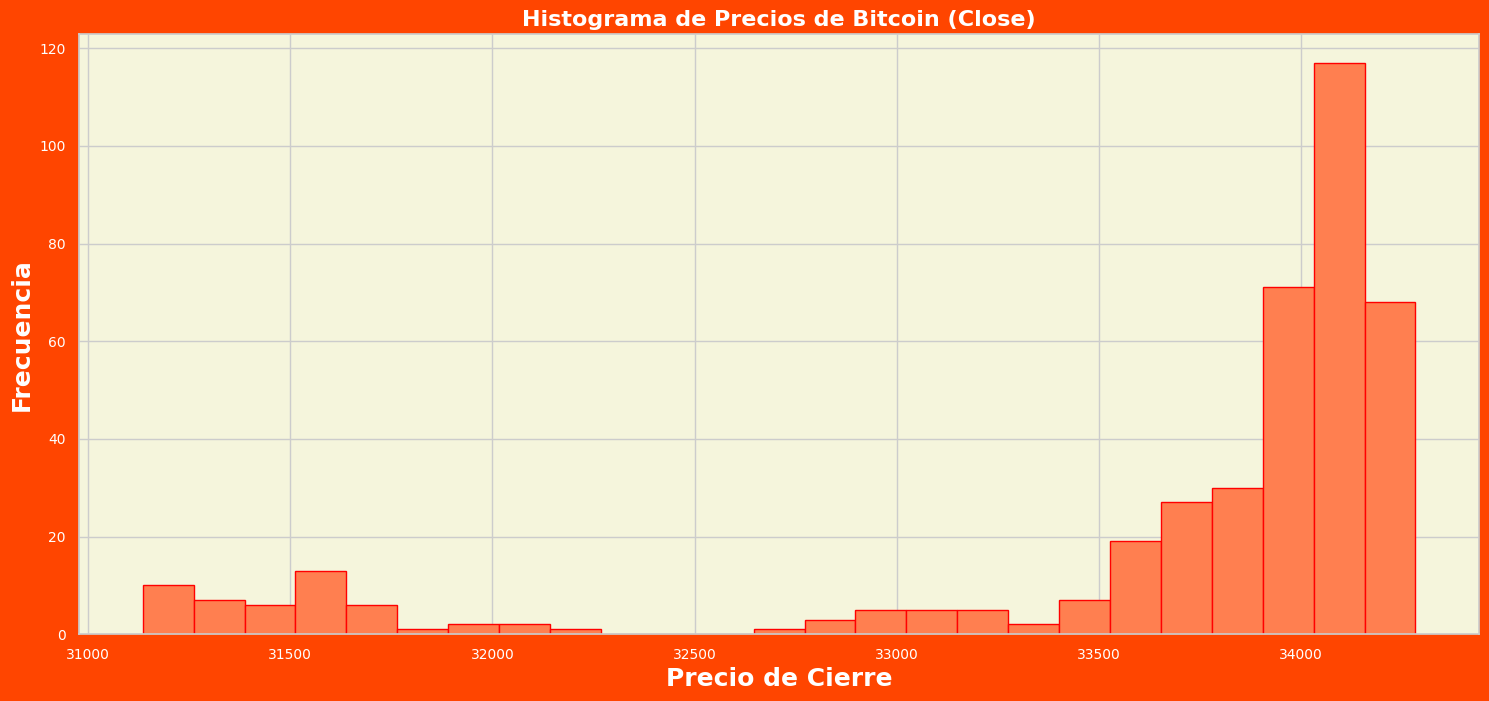

In [9]:
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
fig = plt.figure(figsize=(14,6), facecolor='orangered')
eje = fig.add_axes([0,0,1,1])
eje.tick_params(axis='x', colors='w', labelsize=10)
eje.tick_params(axis='y', colors='w', labelsize=10)

datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']

eje.hist(close, bins=25, color='coral', edgecolor='red')
eje.set_title('Histograma de Precios de Bitcoin (Close)', fontsize=16, fontweight='bold', color='w')
eje.set_xlabel('Precio de Cierre', fontsize=18, fontweight='bold', color='w')
eje.set_ylabel('Frecuencia', fontsize=18, fontweight='bold', color='w')
eje.set_facecolor('beige')
plt.show()

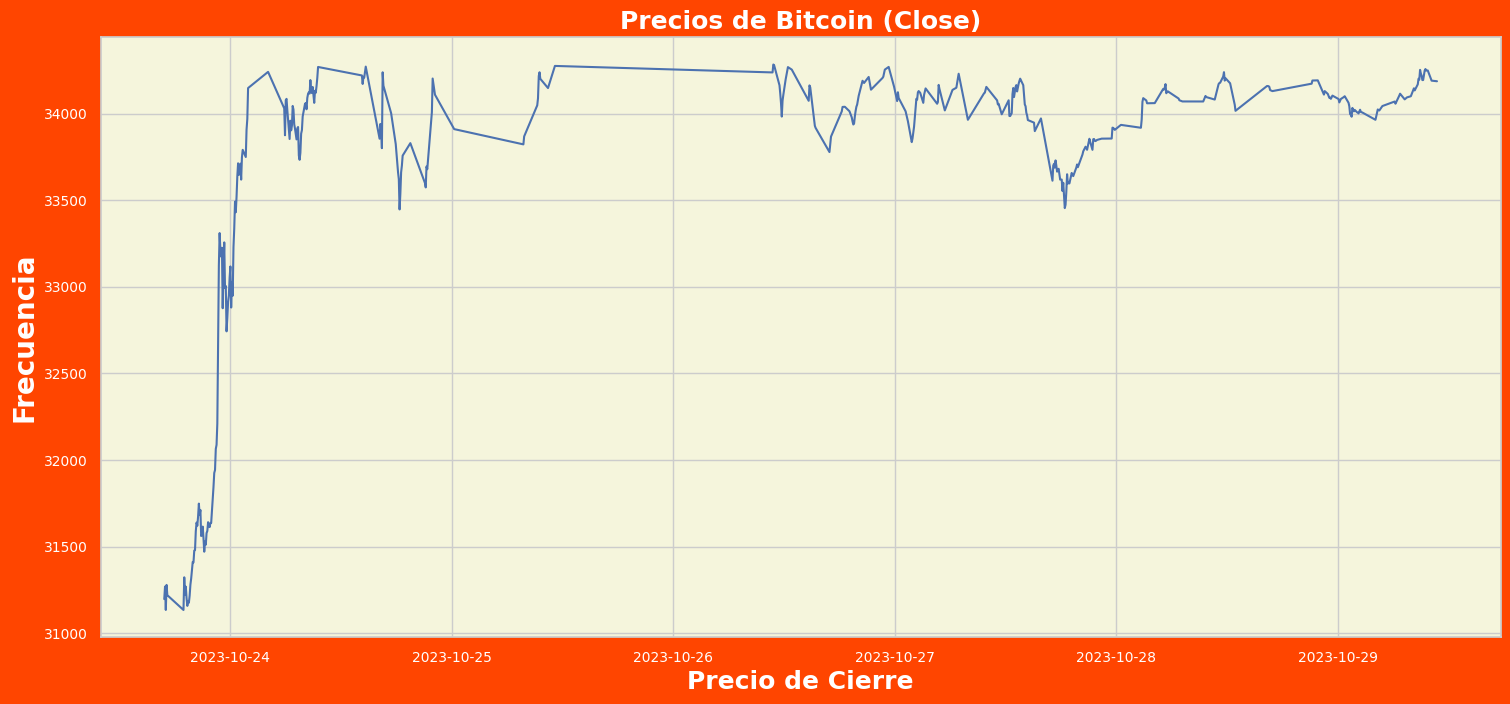

In [10]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(14,6), facecolor='orangered')
eje = fig.add_axes([0,0,1,1])
eje.tick_params(axis='x', colors='w', labelsize=10)
eje.tick_params(axis='y', colors='w', labelsize=10)

datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']

eje.plot(close)
eje.set_title('Precios de Bitcoin (Close)', fontsize=18, fontweight='bold', color='w')
eje.set_xlabel('Precio de Cierre', fontsize=18, fontweight='bold', color='w')
eje.set_ylabel('Frecuencia', fontsize=20, fontweight='bold', color='w')
eje.set_facecolor('beige')
plt.show()

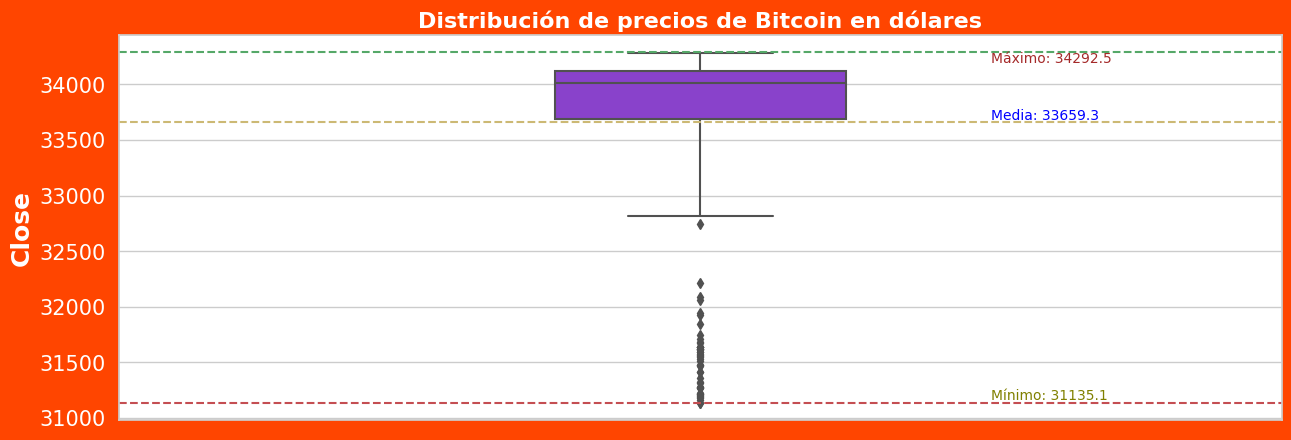

In [14]:
def boxplot1():
  sns.set(style="whitegrid")
  plt.figure(figsize=(15, 5), facecolor='orangered')
  plt.tick_params(axis='x', colors='w', labelsize=15)
  plt.tick_params(axis='y', colors='w', labelsize=15)

  boxplot = sns.boxplot(y='Close', data=df_bitcoin_limpio, color='blueviolet', whis=2, width=0.25)
  plt.ylabel('Close', fontsize=18, color='w', fontweight='bold')
  plt.title('Distribución de precios de Bitcoin en dólares', fontsize=16, color='w',fontweight='bold')

  media = df_bitcoin_limpio['Close'].mean()
  maximo = limpieza_datos()[2]
  minimo = limpieza_datos()[1]

  boxplot.axhline(y=maximo, color='g', linestyle='--')
  boxplot.axhline(y=media, color='y', linestyle='--')
  boxplot.axhline(y=minimo, color='r', linestyle='--')

  plt.text(x=0.25, y=limpieza_datos()[2], s=f'Máximo: {limpieza_datos()[2].round(1)}', fontsize=10, va='top', color='brown')
  plt.text(x=0.25, y=media, s=f'Media: {media.round(1)}', fontsize=10, va='bottom', color='blue')
  plt.text(x=0.25, y=limpieza_datos()[1], s=f'Mínimo: {limpieza_datos()[1].round(1)}', fontsize=10, va='bottom', color='olive')
  return plt.show()

boxplot1()

## 4 -- Tomar Decisiones - Compra, Venta, Espera

In [12]:
# Si el precio actual es mayor/igual que el precio promedio y la tendencia es baja, 'Vender'
# Si el precio actual es menot que el precio promedio y la tendencia alta, 'Comprar'
# Si ninguna de las condiciones anteriores se cumplen, 'Esperar'

def tomar_decisiones():
  global df_bitcoin, precio_actual, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  media_bitcoin = df_bitcoin_limpio['Close'].mean()
  if ((precio_actual >= media_bitcoin) & (tendencia == 'baja')):
    algoritmo_decision = '---> Vender'
  elif ((precio_actual < media_bitcoin) & (tendencia == 'alta')):
    algoritmo_decision = '---> Comprar'
  else:
    algoritmo_decision = '---> Esperar'

  return algoritmo_decision

tomar_decisiones()

'---> Esperar'

# 5 - Visualización de los datos - Variación de los últimos 7 días.

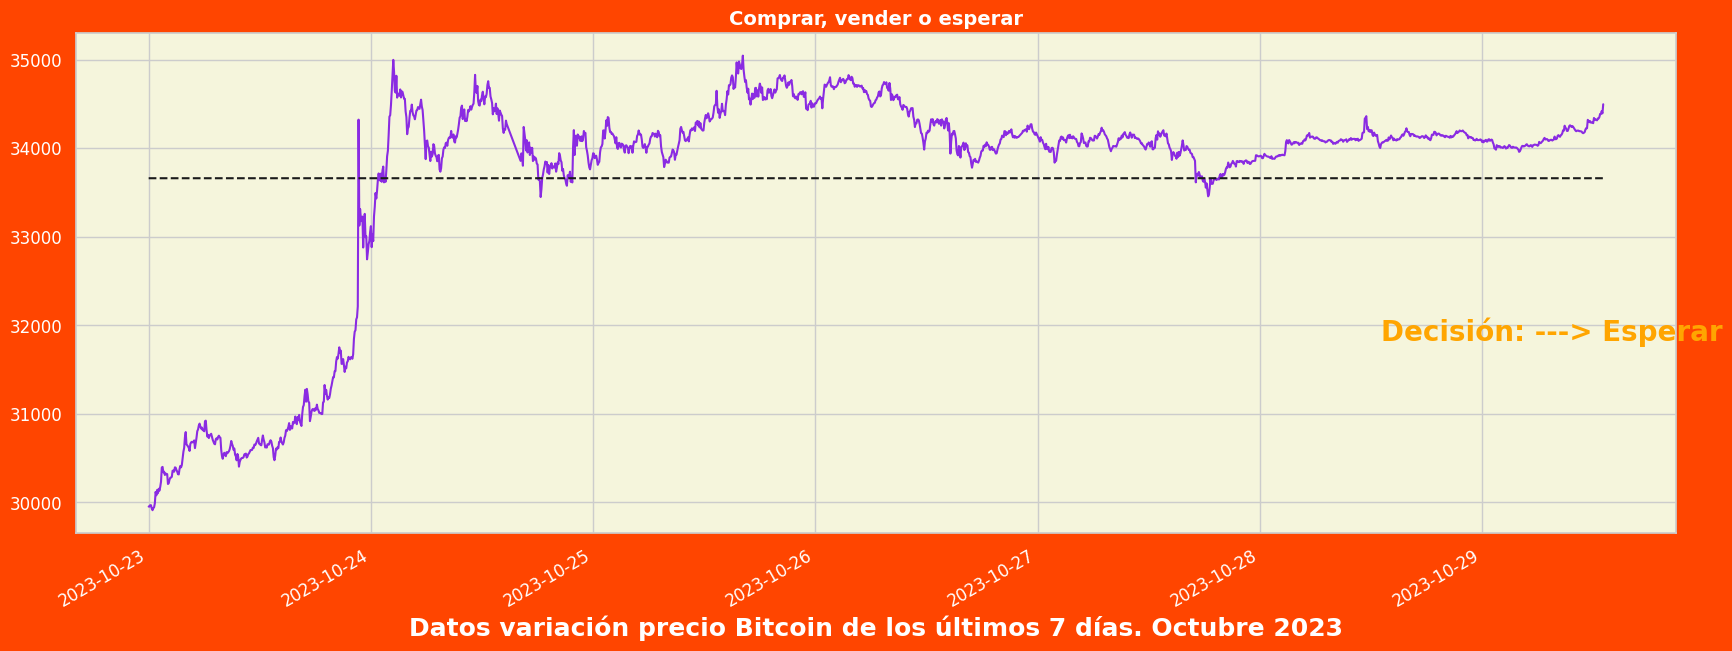

In [13]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  df_bitcoin['Promedio'] = media_bitcoin

  sns.set(style="whitegrid")
  fig = plt.figure(figsize=(16,5), facecolor='orangered')
  eje = fig.add_axes([0,0,1,1])
  eje.tick_params(axis='x', colors='w', labelsize=16)
  eje.tick_params(axis='y', colors='w', labelsize=16)

  eje.set_title('Comprar, vender o esperar', fontsize=14,fontweight='bold', color='w')
  df_bitcoin['Close'].plot(legend = None, color = 'blueviolet')
  df_bitcoin['Promedio'].plot(legend = None, ls='--', color = 'k', fontsize=12)


  eje.set_xlabel('Datos variación precio Bitcoin de los últimos 7 días. Octubre 2023', fontsize=18, fontweight='bold', color='w')
  eje.set_facecolor('beige')
  eje.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-160, -170), textcoords='offset points', fontsize=20, color='orange',fontweight='bold')
  plt.show()

visualizacion()

# 6 - Automatización

Hora de verificación: 10:34:48
Ejecuciones: 5
Decisión: ---> Esperar
Tendencia: alta
Media: 33677
Precio: 34403


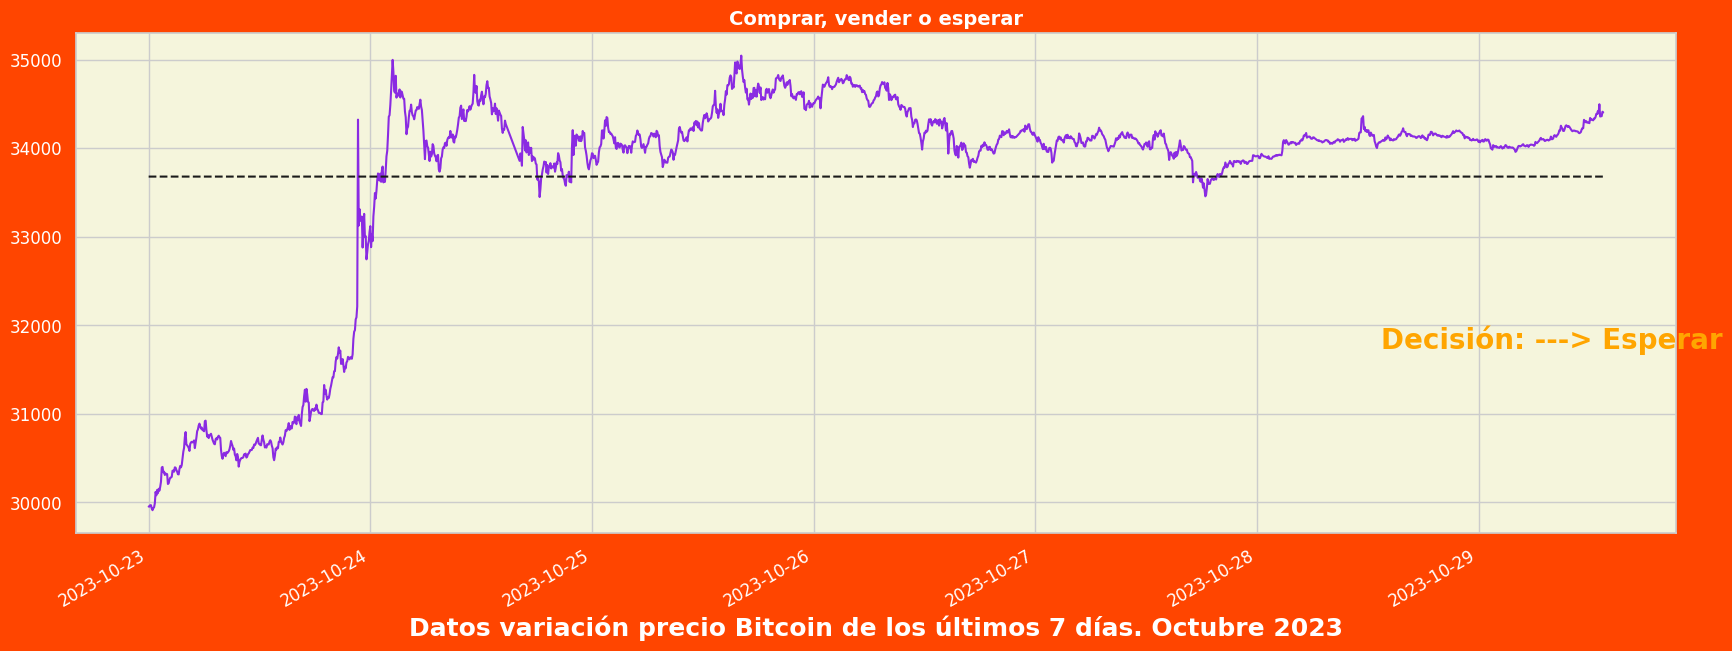

In [ ]:
# El gráfico muestra el histórico del precio Bitcoin y la decisión del algoritmo en tiempo real
# basado en datos normalizados y limpio, que se actualizan cada 5 minutos.

def automatizado():
  contador = 0
  while True:
    contador += 1
    clear_output(wait=True)
    importar_base_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    tz = pytz.timezone('America/Argentina/Buenos_Aires')
    now = datetime.datetime.now(tz)
    print("Hora de verificación:", now.strftime("%H:%M:%S"))
    print(f'Ejecuciones: {contador}')
    print('Decisión:', tomar_decisiones()),print('Tendencia:',tendencia),print('Media:',int(media_bitcoin)),print('Precio:',int(precio_actual))
    visualizacion()
    time.sleep(300)



automatizado()
